# Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import datetime
import re
import warnings
from datetime import datetime
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import scipy.stats as stats
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
#reducing the memory usage before using the dataframes for plotting and modelling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_weather = pd.read_csv('homeB2014.csv')
df_meter = pd.read_csv('HomeB-meter1_2014.csv', parse_dates=[0], index_col=[0])

In [ ]:
df_weather = reduce_mem_usage(df_weather)
df_meter = reduce_mem_usage(df_meter)

In [4]:
df_weather.shape

(8760, 14)

In [5]:
df_weather.head()

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,20.31,clear-night,0.47,10.0,Clear,7.74,1023.25,12.65,0.0,1388552400,283,0.0,3.30,0.0
1,19.22,clear-night,0.48,10.0,Clear,7.89,1023.21,9.99,0.0,1388556000,283,0.0,2.69,0.0
2,18.10,clear-night,0.52,10.0,Clear,8.11,1024.25,7.76,0.0,1388559600,255,0.0,3.42,0.0
3,17.47,clear-night,0.55,10.0,Clear,7.36,1025.02,7.73,0.0,1388563200,245,0.0,4.00,0.0
4,15.63,clear-night,0.61,10.0,Clear,6.98,1025.16,5.76,0.0,1388566800,220,0.0,4.45,0.0


# Data Preprocessing and EDA

**Weather data exists from Jan 1, 2014 to Dec 31, 2014 on an hourly basis. Meter data exists from Jan 1, 2014 to Dec 31, 2014 on half-hourly basis. Icon and Summary columns from weather data are useless and hence discarded. gen [kW] and Grid [kW] columns either contain repeated data or no data at all and hence discarded. Also, weather data is converted to EST and both dataframes are indexed on date and time column. To combine both the data into a single dataframe, the meter dataframe is resampled on hourly basis and then both of them are merged to get a combined dataframe.**

In [6]:
df_weather = df_weather.drop(['icon', 'summary'], axis=1)
df_weather['Date & Time'] = pd.to_datetime(df_weather['time'], unit='s')
df_weather['Date & Time'] = df_weather['Date & Time'] - pd.Timedelta(hours=5)
df_weather.index = df_weather['Date & Time']

In [7]:
df_weather = df_weather.drop(['Date & Time', 'time'], axis=1)

In [8]:
df_weather.head()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date & Time,,,,,,,,,,,
2014-01-01 00:00:00,20.31,0.47,10.0,7.74,1023.25,12.65,0.0,283,0.0,3.30,0.0
2014-01-01 01:00:00,19.22,0.48,10.0,7.89,1023.21,9.99,0.0,283,0.0,2.69,0.0
2014-01-01 02:00:00,18.10,0.52,10.0,8.11,1024.25,7.76,0.0,255,0.0,3.42,0.0
2014-01-01 03:00:00,17.47,0.55,10.0,7.36,1025.02,7.73,0.0,245,0.0,4.00,0.0
2014-01-01 04:00:00,15.63,0.61,10.0,6.98,1025.16,5.76,0.0,220,0.0,4.45,0.0


In [9]:
df_weather.shape

(8760, 11)

In [10]:
df_meter.shape

(17520, 17)

In [11]:
df_meter.head()

,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
Date & Time,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589
2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008
2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928
2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472
2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798


In [12]:
df_meter = df_meter.drop(['gen [kW]', 'Grid [kW]'], axis=1)

In [13]:
df_meter = df_meter.resample('H').mean()

In [14]:
df_meter.shape

(8760, 15)

In [15]:
df_meter_hourly = df_meter
df_weather_hourly = df_weather
df_meter_daily = df_meter_hourly.resample('D').mean()
df_weather_daily = df_weather_hourly.resample('D').mean()

In [16]:
comb_df_hourly = pd.merge(df_meter_hourly, df_weather_hourly, left_index=True, right_index =True, how='left')
comb_df_daily = pd.merge(df_meter_daily, df_weather_daily, left_index=True, right_index =True, how='left')

In [17]:
comb_df_hourly.shape

(8760, 26)

In [18]:
comb_df_daily.shape

(365, 26)

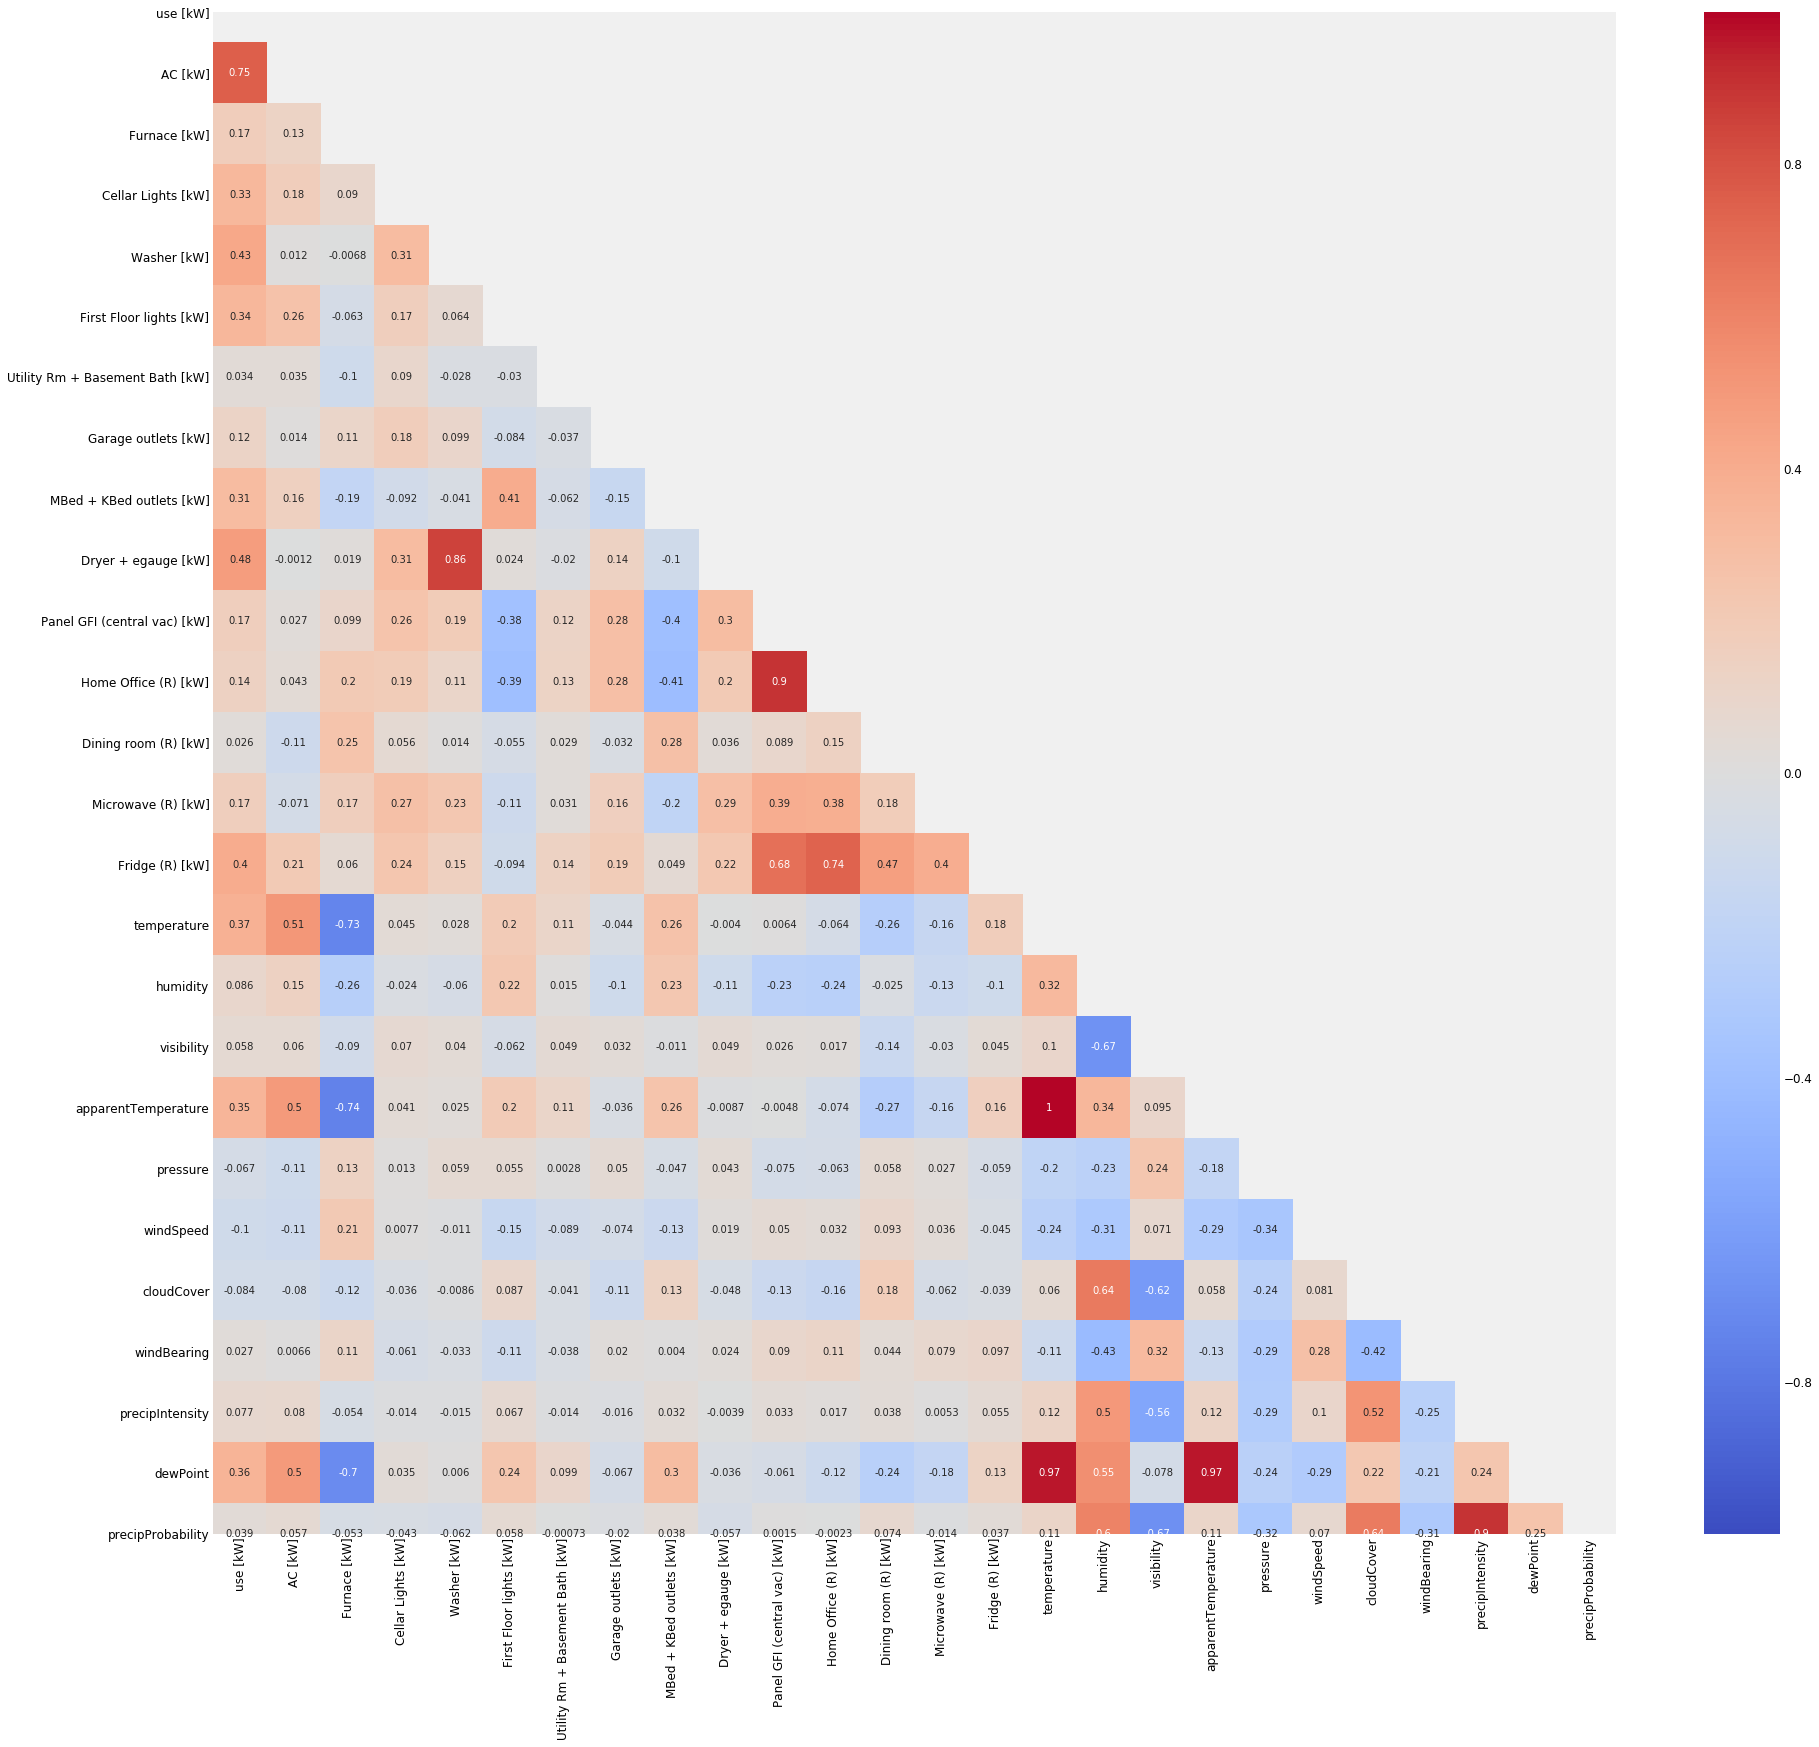

In [19]:
corr = comb_df_daily.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(28,28))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, mask = mask, vmin=-1)

In [20]:
#dropping apparentTemperature as it almost conveys the same info as temperature. Dryer consumption has high
#correlation with washer consumption and hence dropped. precipProbability has very high correlation with precipIntensity
#and hence dropped
comb_df_daily = comb_df_daily.drop(['apparentTemperature', 'Dryer + egauge [kW]', 'precipProbability'], axis=1)

In [21]:
#taking log for pressure values
comb_df_daily['pressure'] = comb_df_daily['pressure'].apply(np.log)

In [22]:
def remove_braces(df):
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns]
    return df

In [23]:
#remving braces from feature names as XGBoost doesn't allow braces
comb_df_daily = remove_braces(comb_df_daily)

In [24]:
comb_df_daily.shape

(365, 23)

In [25]:
comb_df_daily.isna().sum()

use _kW_                           0
AC _kW_                            0
Furnace _kW_                       0
Cellar Lights _kW_                 0
Washer _kW_                        0
First Floor lights _kW_            0
Utility Rm + Basement Bath _kW_    0
Garage outlets _kW_                0
MBed + KBed outlets _kW_           0
Panel GFI (central vac) _kW_       0
Home Office (R) _kW_               0
Dining room (R) _kW_               0
Microwave (R) _kW_                 0
Fridge (R) _kW_                    0
temperature                        0
humidity                           0
visibility                         0
pressure                           0
windSpeed                          0
cloudCover                         0
windBearing                        0
precipIntensity                    0
dewPoint                           0
dtype: int64

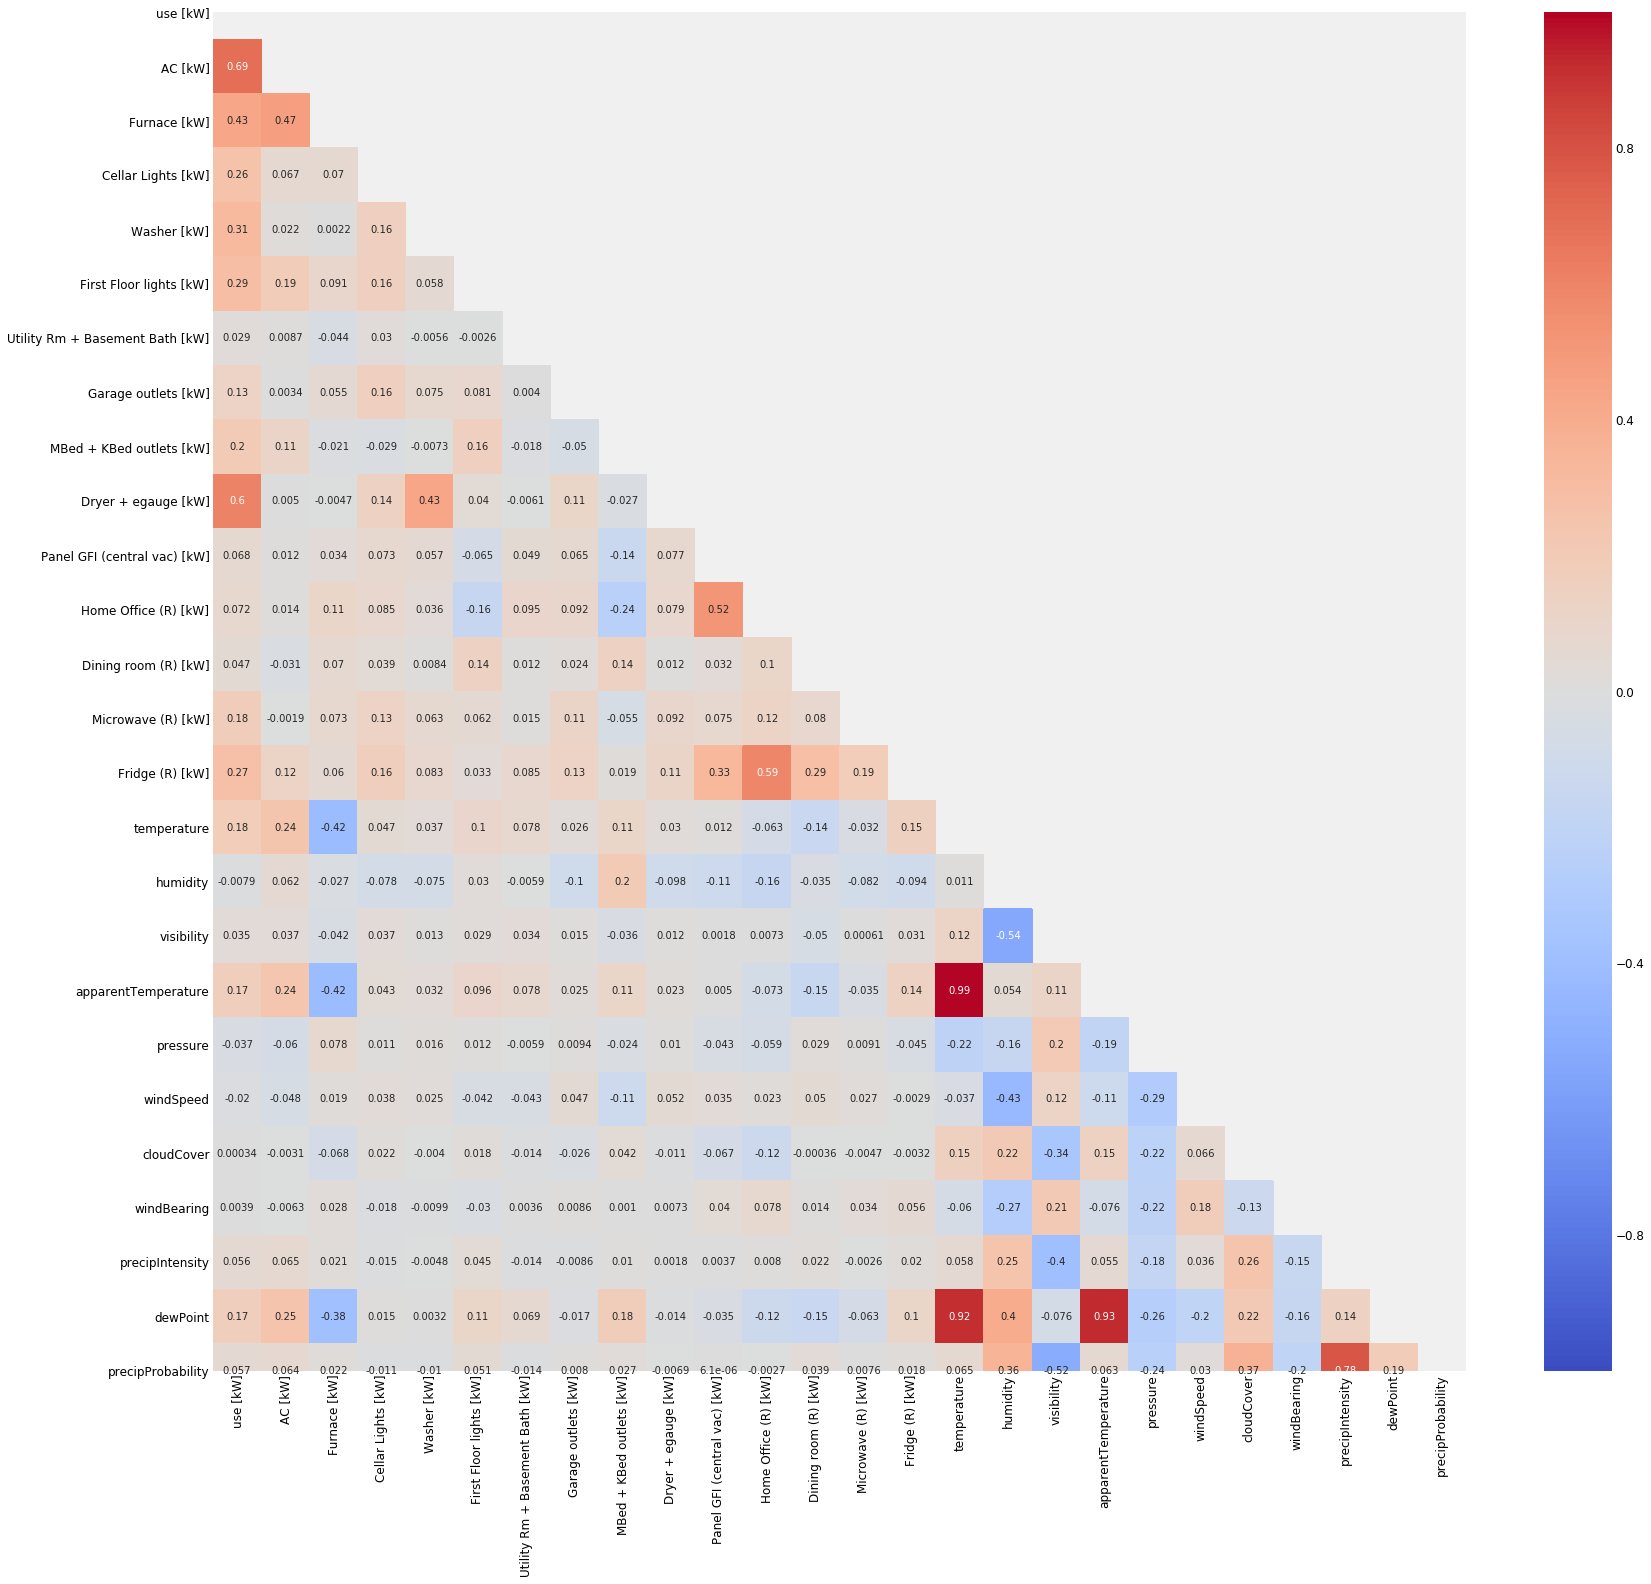

In [26]:
corr = comb_df_hourly.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25,25))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, mask = mask, vmin=-1)

In [27]:
#dropping apparentTemperature as it almost conveys the same info as temperature. precipProbability has very high correlation
#with precipIntensity and hence dropped
comb_df_hourly = comb_df_hourly.drop(['apparentTemperature', 'precipProbability'], axis=1)
comb_df_hourly['pressure'] = comb_df_hourly['pressure'].apply(np.log)
comb_df_hourly = remove_braces(comb_df_hourly)
comb_df_hourly.shape

(8760, 24)

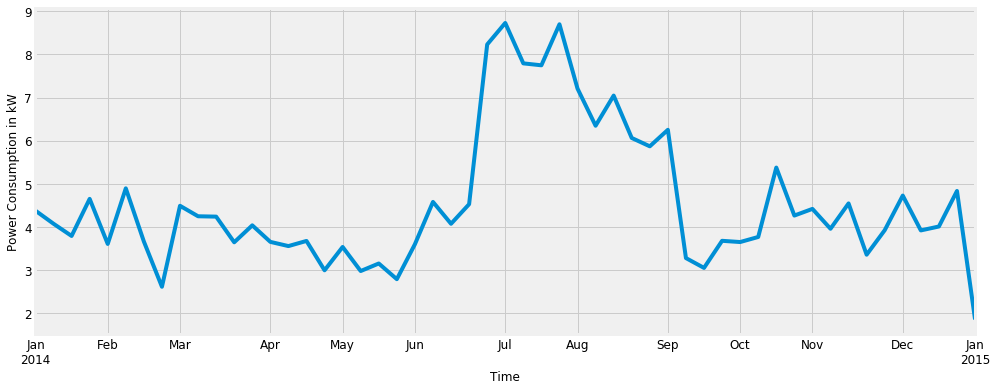

In [28]:
weekly_summary = pd.DataFrame()
weekly_summary['visibility'] = comb_df_daily.visibility.resample('W').mean()
weekly_summary['use [kW]'] = comb_df_daily['use _kW_'].resample('W').sum()
ax = weekly_summary['use [kW]'].plot(figsize=(15, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Power Consumption in kW')
plt.show()

**The electricity consumption for House B is as shown above. It is highly irregular trended and we see a sharp rise
in the usage mid-June till September. The rest of the months in the year show some spikes.**

# Feature Engineering

In [94]:
#Thi baseline model simply takes 80% of data as train data and uses it to predict on remaning training data using data
#of previous 2 samples for each sample in the train set
def baseline_model(series):
    X = series.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # predict
        yhat = history[-2]
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)

    # report performance
    mae = mean_absolute_error(test, predictions)
    print('MAE of baseline model: %.3f' % mae)
    return mae

## Hourly Data
**We add lagged features for weather related data in the dataframe so that our models can learn more from the data. All
weather related features for last 7 samples are added as new features for each sample in the hourly dataframe.**

In [140]:
# Build lagged weather predictors
lagged_df = comb_df_hourly.copy()

# Next hour's load values.
lagged_df['load_hour_after'] = lagged_df['use _kW_'].shift(-1)    

for day in range(8):
    lagged_df['temperature_d' + str(day)] = lagged_df.temperature.shift(day)
    lagged_df['windSpeed_d' + str(day)] = lagged_df.windSpeed.shift(day)
    lagged_df['humidity_d' + str(day)] = lagged_df.humidity.shift(day)
    lagged_df['pressure_d' + str(day)] = lagged_df.pressure.shift(day)
    lagged_df['cloudCover_d' + str(day)] = lagged_df.cloudCover.shift(day)
    lagged_df['windBearing_d' + str(day)] = lagged_df.windBearing.shift(day)
    lagged_df['precipIntensity_d' + str(day)] = lagged_df.precipIntensity.shift(day)
    lagged_df['dewPoint_d' + str(day)] = lagged_df.dewPoint.shift(day)
    lagged_df['load_d' + str(day)] = lagged_df['use _kW_'].shift(day)

     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['temperature', 'windSpeed', 'humidity', 'pressure', 'cloudCover',
                                    'windBearing', 'precipIntensity', 'dewPoint','use _kW_'])

In [141]:
X = lagged_df.drop(columns=['load_hour_after'])
y = lagged_df['load_hour_after']

In [142]:
X.shape

(5929, 87)

In [143]:
y.shape

(5929,)

# Data Modelling
**We split the data into a time series split with number of slits as 10. This is used to evaluate cross-validation mean absolute errors for models. We also split the data in the ratio of 80:20 for traning and testing respectively. Out of this 80% data, all data points are also used for cross-validation. We train 10 models using this test data and also calculate their corss-validation MAE. We also create our own Blender model that weighs the prediction of each of these models to give a single prediction.**

In [42]:
tscv = TimeSeriesSplit(n_splits=10)

In [43]:
def cv_mae(model, X, y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=tscv)
    return (mae)

In [44]:
def mae(y, y_pred):
    return mean_absolute_error(y, y_pred)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [87]:
print('Building model...')

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=tscv))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=tscv))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=tscv, l1_ratio=e_l1ratio))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0004,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=4, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, loss='huber', random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.005, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=4060,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00005)

adaboost = AdaBoostRegressor()

extratrees = ExtraTreesRegressor()

bagging = BaggingRegressor()

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm, adaboost, extratrees, bagging),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

#Store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'SVR': svr,
          'GBR': gbr,
          'LightGBM': lightgbm,
          'XGBoost': xgboost,
         'AdaBoost': adaboost,
         'Extratrees': extratrees,
         'Bagging': bagging}
scores = {}

#Evaluating model score
print('Evaluating model cross-validation scores...')
for name, model in models.items():    
    score = cv_mae(model, X_train, y_train)
    print((name + ": {:.4f} ({:.4f})\n").format(score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())
    
print('Done evaluating')

print('Fitting models...')

print('Fitting StackingRegressor...')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('Fitting ElasticNet...')
elastic_model_full_data = elasticnet.fit(X_train,y_train)

print('Fitting Lasso...')
lasso_model_full_data = lasso.fit(X_train,y_train)

print('Fitting Ridge...')
ridge_model_full_data = ridge.fit(X_train,y_train)

print('Fitting SVR...')
svr_model_full_data = svr.fit(X_train,y_train)

print('Fitting GradientBoosting...')
gbr_model_full_data = gbr.fit(X_train,y_train)

print('Fitting XGBoost...')
xgb_model_full_data = xgboost.fit(X_train,y_train)

print('Fitting LightGBM...')
lgb_model_full_data = lightgbm.fit(X_train,y_train)

print('Fitting AdaBoost...')
adaboost_model_full_data = adaboost.fit(X_train,y_train)

print('Fitting extratrees...')
extratrees_model_full_data = extratrees.fit(X_train,y_train)

print('Fitting Bagging...')
bagging_model_full_data = bagging.fit(X_train,y_train)

print('Done fitting all models')

Building model...
Evaluating model cross-validation scores...
Ridge: 0.4854 (0.3493)

Lasso: 0.5069 (0.3925)

ElasticNet: 0.5111 (0.4012)

SVR: 0.3742 (0.2091)

GBR: 0.3326 (0.1847)

LightGBM: 0.3577 (0.1868)

[19:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:55] WARNING: /workspa

In [88]:
#Blending model predictions
print('Blending model predictions...')
def blend_models_predict(X):
    return ((0.045 * elastic_model_full_data.predict(X))+(0.05 * lasso_model_full_data.predict(X))
            +(0.05 * ridge_model_full_data.predict(X)) + (0.1 * svr_model_full_data.predict(X))
            +(0.15 * gbr_model_full_data.predict(X))+(0.1 * xgb_model_full_data.predict(X))
            +(0.0005 * extratrees_model_full_data.predict(X))
            +(0.0005 * bagging_model_full_data.predict(X))
            +(0.001 * lgb_model_full_data.predict(X))+(0.5 * stack_gen_model.predict(np.array(X))))

mae_score = mae(y_train, blend_models_predict(X_train))
print('MAE score on train data:' + str(mae_score))
scores['Blender'] = (mae_score.mean(), mae_score.std())

Blending model predictions...
MAE score on train data:0.11660981114692005


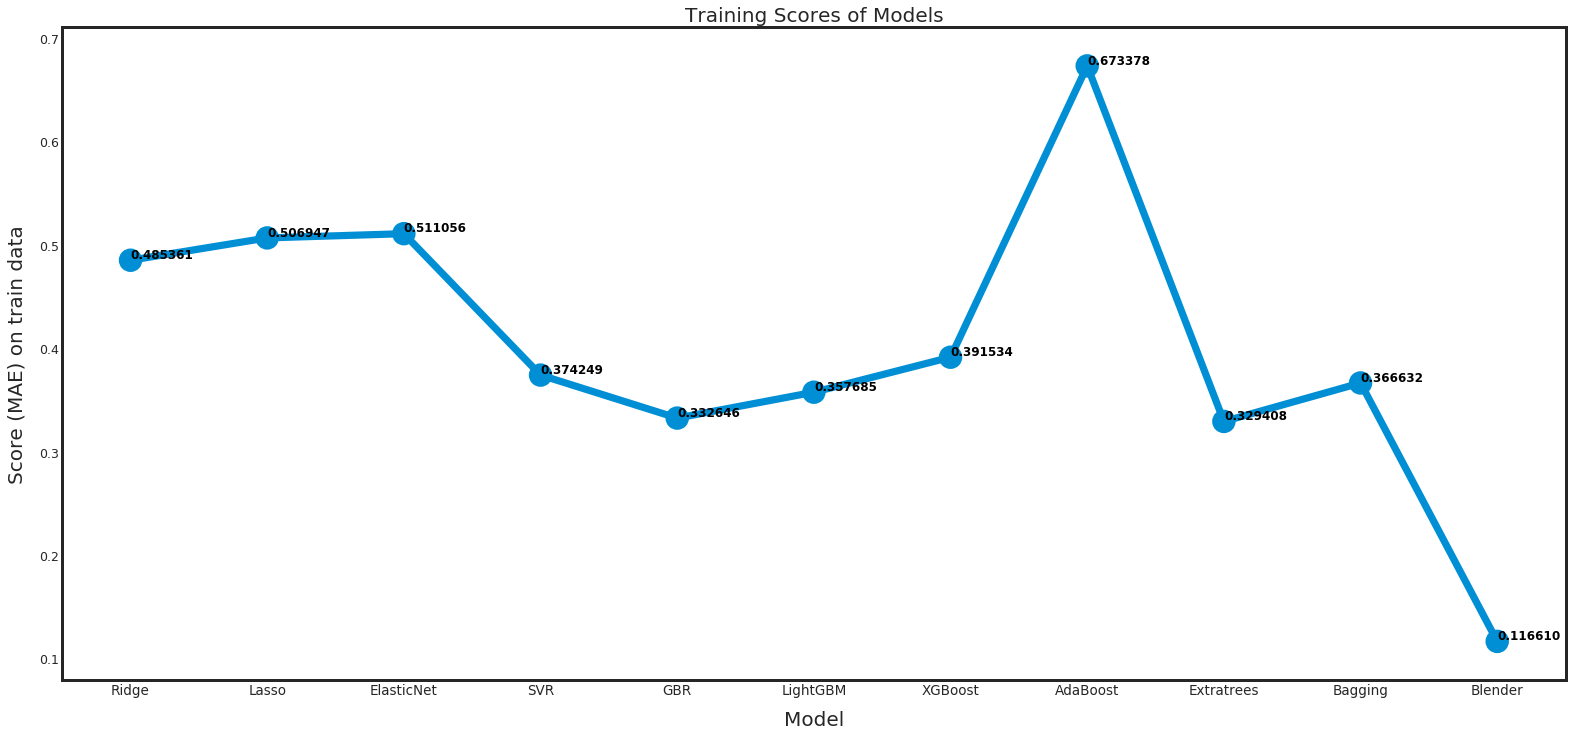

In [89]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on train data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Training Scores of Models', size=20)

plt.show()

**As shown above, Adaboost model has the highest traning MAE of 0.673 while the Blender model has the least MAE of 0.116. All the other models give an MAE between these values with a slight difference in each of them.**

In [90]:
#Store models, scores and prediction values 
test_models = {'Ridge': ridge_model_full_data,
          'Lasso': lasso_model_full_data, 
          'ElasticNet': elastic_model_full_data,
          'SVR': svr_model_full_data,
          'GBR': gbr_model_full_data,
          'LightGBM': lgb_model_full_data,
          'XGBoost': xgb_model_full_data,
         'AdaBoost': adaboost_model_full_data,
         'Extratrees': extratrees_model_full_data,
         'Bagging': bagging_model_full_data}
test_scores = {}

#Evaluating model score
print('Evaluating model test scores...')
for name, model in test_models.items():    
    score = mae( y_test, model.predict(X_test))
    print((name + ": {:.4f} \n").format(score))
    test_scores[name] = score

Evaluating model test scores...
Ridge: 0.2052 

Lasso: 0.2029 

ElasticNet: 0.2033 

SVR: 0.1837 

GBR: 0.1944 

LightGBM: 0.1833 

XGBoost: 0.1974 

AdaBoost: 0.9316 

Extratrees: 0.2238 

Bagging: 0.2057 



In [91]:
blender_score = mae(y_test, blend_models_predict(X_test))
test_scores['Blender'] = blender_score
print('MAE score of blender on test data:' + str(blender_score))

MAE score of blender on test data:0.18318884709347982


In [95]:
baseline_score = baseline_model(y)
test_scores['Baseline'] = baseline_score

MAE of baseline model: 0.238


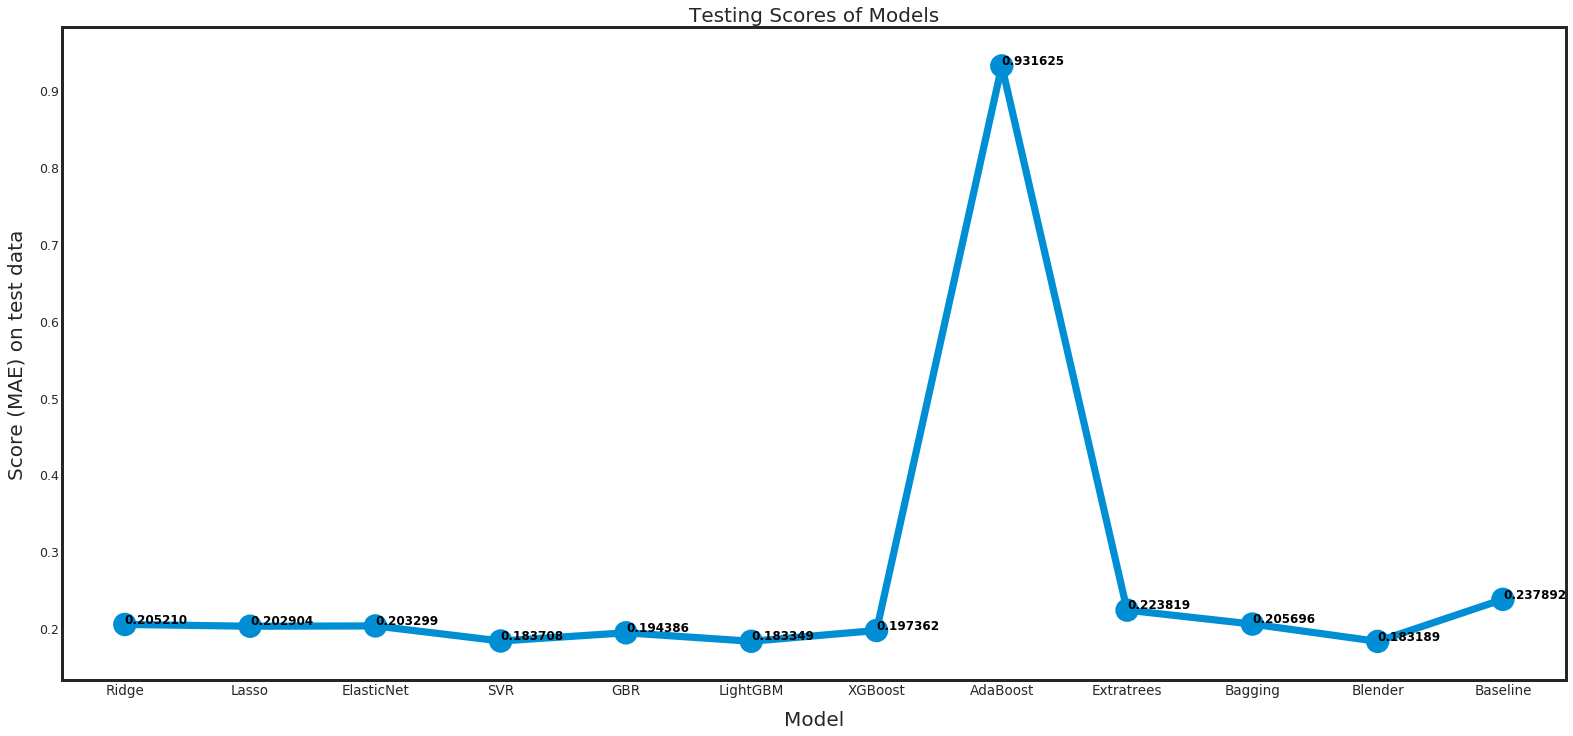

In [96]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(test_scores.keys()), y=[score for score in test_scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(test_scores.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on test data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Testing Scores of Models', size=20)

plt.show()

**As shown above, similar to the training data, Adaboost model has the highest testing MAE of 0.931 while the Blender model has the least MAE of 0.183. All the other models give an MAE between these values with a slight difference in each of them. Our baseline mode has the MAE of 0.237 which is higher than most of the individual models except AdaBoost. With the help of blender model, we get and MAE better than all the models as well as the baseline model.**

In [103]:
def plot_prediction_multistep(actual, prediction, start_date, title, prediction_label):
    date_rng = pd.date_range(start=start_date, periods=24, freq='H')
    plt.figure(figsize=(30,5))
    plt.title(title)
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, prediction, label=prediction_label)
    plt.ylabel('Power(kW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.show()

In [152]:
def get_features(date, comb_df):
    features = comb_df_hourly.loc[date]
    #print(features)
    
    for day in range(8):
        features['temperature_d' + str(day)] = comb_df_hourly.temperature.shift(day)
        features['windSpeed_d' + str(day)] = comb_df_hourly.windSpeed.shift(day)
        features['humidity_d' + str(day)] = comb_df_hourly.humidity.shift(day)
        features['pressure_d' + str(day)] = comb_df_hourly.pressure.shift(day)
        features['cloudCover_d' + str(day)] = comb_df_hourly.cloudCover.shift(day)
        features['windBearing_d' + str(day)] = comb_df_hourly.windBearing.shift(day)
        features['precipIntensity_d' + str(day)] = comb_df_hourly.precipIntensity.shift(day)
        features['dewPoint_d' + str(day)] = comb_df_hourly.dewPoint.shift(day)
        features['load_d' + str(day)] = comb_df_hourly['use _kW_'].shift(day)

    
    features = features.dropna()
    #print(features)
    
    features = features.drop(columns=['temperature', 'windSpeed', 'humidity', 'pressure', 'cloudCover',
                                    'windBearing', 'precipIntensity', 'dewPoint','use _kW_'])

    return features

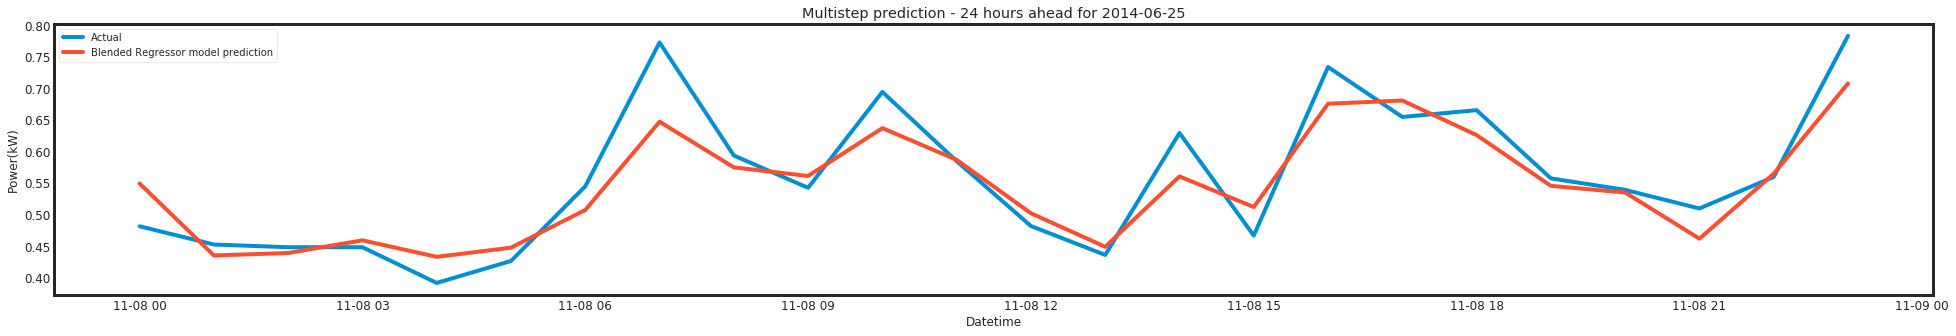

In [165]:
date = '2014-11-08'
prediction = blend_models_predict(get_features(date, comb_df_hourly))
plot_prediction_multistep(actual=comb_df_hourly['use _kW_'].loc[date],prediction=prediction, start_date=date, title='Multistep prediction - 24 hours ahead for 2014-06-25',
                prediction_label='Blended Regressor model prediction') 

**The above graph is a sample prediction of Blender model for hourly electricity consumption on 2014-06-25. The model fits the
actual consuption quite well.**

## Daily Data
**Unlike for the hourly data, we don't add any lagged features for the daily data. Rest of the data split and traning procedure is the same as above.**

In [272]:
X = comb_df_daily.drop(columns = ['use _kW_'])
y = comb_df_daily['use _kW_']

In [273]:
X.shape

(365, 22)

In [274]:
y.shape

(365,)

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [276]:
print('Building model...')

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=tscv))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=tscv))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=tscv, l1_ratio=e_l1ratio))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0004,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=4, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, loss='huber', random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.005, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=4060,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00005)

adaboost = AdaBoostRegressor()

extratrees = ExtraTreesRegressor()

bagging = BaggingRegressor()

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm, adaboost, extratrees, bagging),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

#Store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'SVR': svr,
          'GBR': gbr,
          'LightGBM': lightgbm,
          'XGBoost': xgboost,
         'AdaBoost': adaboost,
         'Extratrees': extratrees,
         'Bagging': bagging}
scores = {}

#Evaluating model score
print('Evaluating model cross-validation scores...')
for name, model in models.items():    
    score = cv_mae(model, X_train, y_train)
    print((name + ": {:.4f} ({:.4f})\n").format(score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())
    
print('Done evaluating')

print('Fitting models...')

print('Fitting StackingRegressor...')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('Fitting ElasticNet...')
elastic_model_full_data = elasticnet.fit(X_train,y_train)

print('Fitting Lasso...')
lasso_model_full_data = lasso.fit(X_train,y_train)

print('Fitting Ridge...')
ridge_model_full_data = ridge.fit(X_train,y_train)

print('Fitting SVR...')
svr_model_full_data = svr.fit(X_train,y_train)

print('Fitting GradientBoosting...')
gbr_model_full_data = gbr.fit(X_train,y_train)

print('Fitting XGBoost...')
xgb_model_full_data = xgboost.fit(X_train,y_train)

print('Fitting LightGBM...')
lgb_model_full_data = lightgbm.fit(X_train,y_train)

print('Fitting AdaBoost...')
adaboost_model_full_data = adaboost.fit(X_train,y_train)

print('Fitting extratrees...')
extratrees_model_full_data = extratrees.fit(X_train,y_train)

print('Fitting Bagging...')
bagging_model_full_data = bagging.fit(X_train,y_train)

print('Done fitting all models')

Building model...
Evaluating model cross-validation scores...
Ridge: 2.2889 (6.4635)

Lasso: 6.3375 (18.5505)

ElasticNet: 6.3712 (18.6492)

SVR: 0.1461 (0.1139)

GBR: 0.1674 (0.0779)

LightGBM: 0.1701 (0.0686)

[22:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:05] WARNING: /works

In [277]:
#Blending model predictions
print('Blending model predictions...')
def blend_models_predict(X):
    return ((0.15 * adaboost_model_full_data.predict(X))
            +(0.05 * ridge_model_full_data.predict(X)) + (0.1 * svr_model_full_data.predict(X))
            +(0.15 * gbr_model_full_data.predict(X))+(0.1 * xgb_model_full_data.predict(X))
            +(0.015 * extratrees_model_full_data.predict(X))
            +(0.005 * bagging_model_full_data.predict(X))
            +(0.001 * lgb_model_full_data.predict(X))+(0.5 * stack_gen_model.predict(np.array(X))))

mae_score = mae(y_train, blend_models_predict(X_train))
print('MAE score on train data:' + str(mae_score))
scores['Blender'] = (mae_score.mean(), mae_score.std())

Blending model predictions...
MAE score on train data:0.04970726199886958


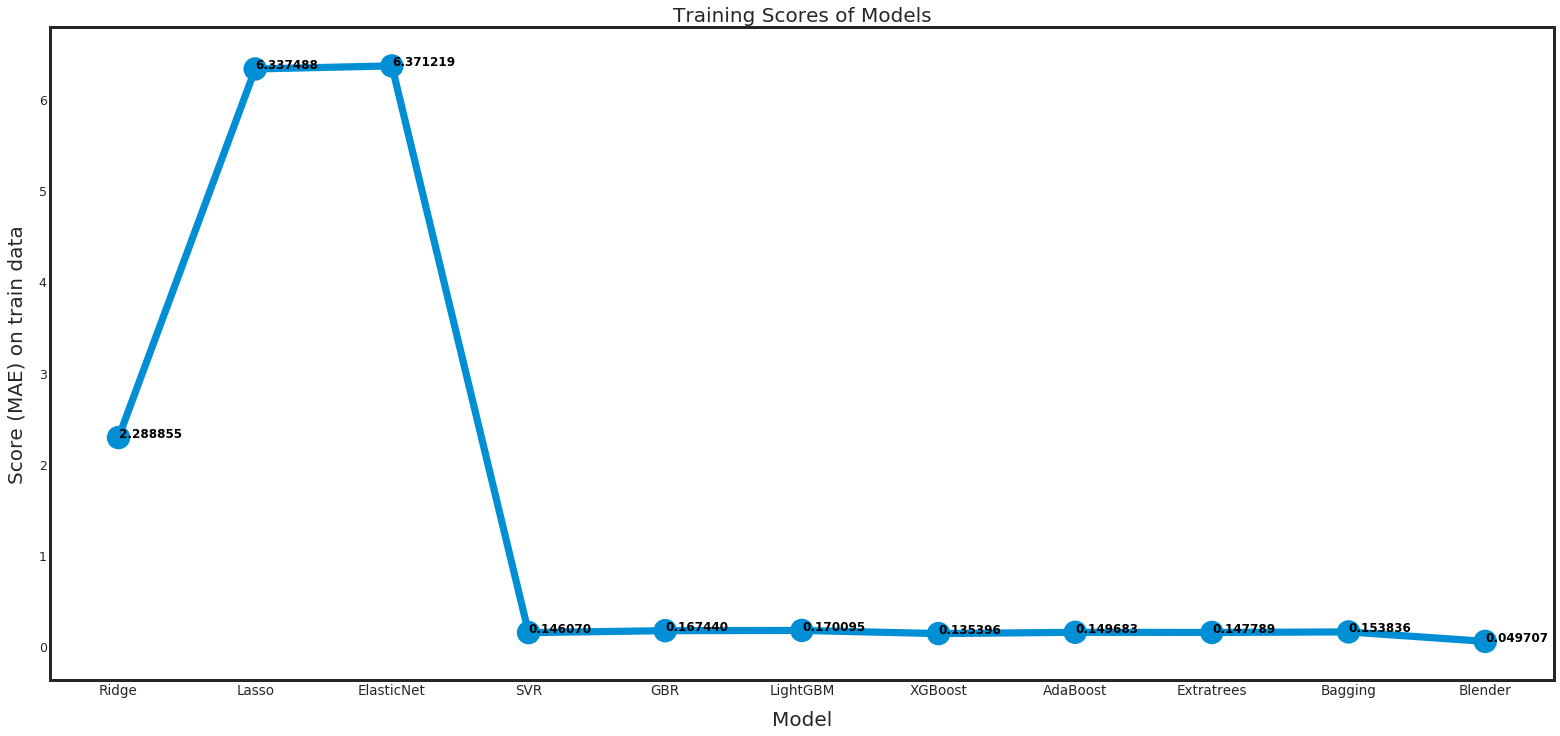

In [278]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on train data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Training Scores of Models', size=20)

plt.show()

**As shown above, Lasso and ElasticNet models have the highest traning MAE of 6.3 while the Blender model has the least MAE of 0.049. All the other models give an MAE which is very lower than Lasso and ElasticNet but Blender model beats them all.**

In [279]:
#Store models, scores and prediction values 
test_models = {'Ridge': ridge_model_full_data,
          'Lasso': lasso_model_full_data, 
          'ElasticNet': elastic_model_full_data,
          'SVR': svr_model_full_data,
          'GBR': gbr_model_full_data,
          'LightGBM': lgb_model_full_data,
          'XGBoost': xgb_model_full_data,
         'AdaBoost': adaboost_model_full_data,
         'Extratrees': extratrees_model_full_data,
         'Bagging': bagging_model_full_data}
test_scores = {}

#Evaluating model score
print('Evaluating model test scores...')
for name, model in test_models.items():    
    score = mae( y_test, model.predict(X_test))
    print((name + ": {:.4f} \n").format(score))
    test_scores[name] = score

Evaluating model test scores...
Ridge: 0.1200 

Lasso: 0.1528 

ElasticNet: 0.1532 

SVR: 0.1164 

GBR: 0.1269 

LightGBM: 0.1349 

XGBoost: 0.1215 

AdaBoost: 0.1227 

Extratrees: 0.1190 

Bagging: 0.1236 



In [280]:
blender_score = mae(y_test, blend_models_predict(X_test))
test_scores['Blender'] = blender_score
print('MAE score of blender on test data:' + str(blender_score))

baseline_score = baseline_model(y)
test_scores['Baseline'] = baseline_score

MAE score of blender on test data:0.11192766971346499
MAE of baseline model: 0.133


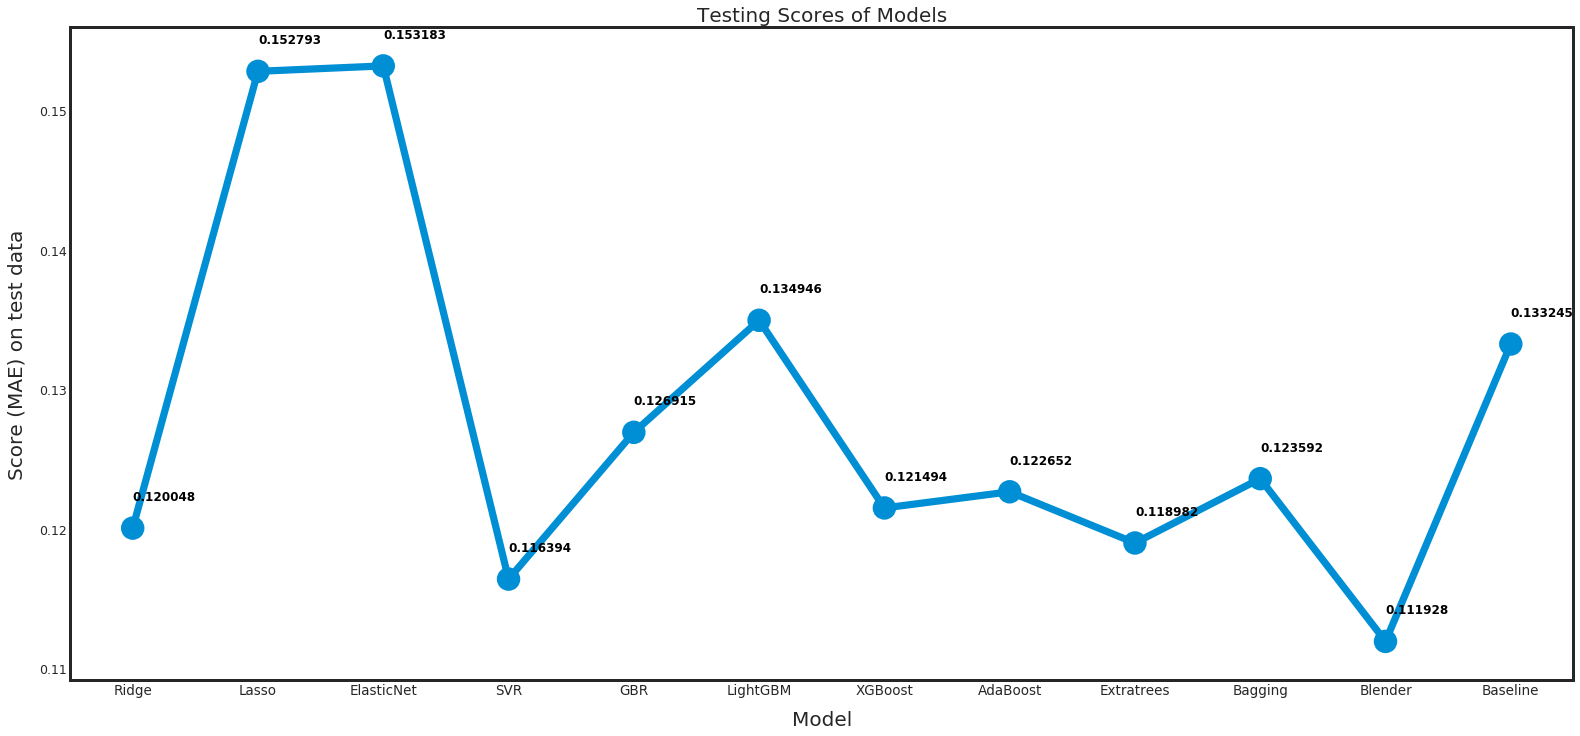

In [281]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(test_scores.keys()), y=[score for score in test_scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(test_scores.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on test data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Testing Scores of Models', size=20)

plt.show()

**As shown above, similar to the training data, Lasso and ElasticeNet models have the highest testing MAE of 0.15 while the Blender model has the least MAE of 0.111. All the other models give an MAE between these values with a slight difference in each of them. Our baseline mode has the MAE of 0.133 which is higher than most of the individual models except Lasso and ElasticNet. With the help of blender model, we get and MAE better than all the models as well as the baseline model.**

In [285]:
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)

    axes[0].set_title('Actual vs Prediction - One week')
    axes[0].set_ylabel('Power(kW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=actual.index[-7] , right=actual.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One month')
    axes[1].set_ylabel('Power(kW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()

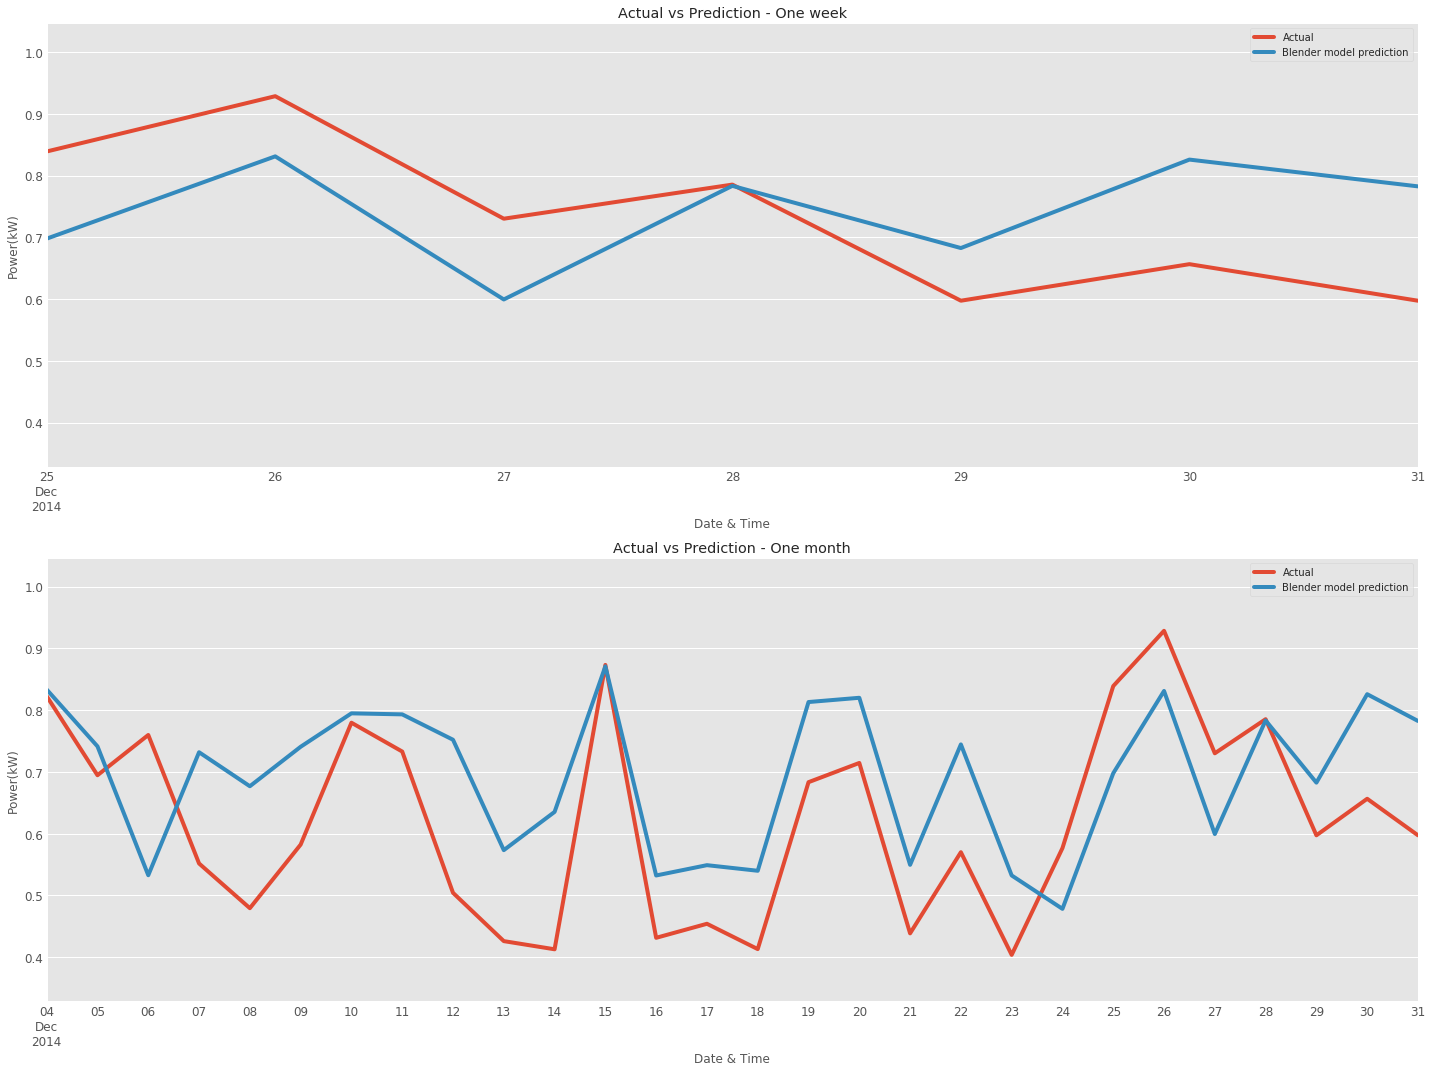

In [286]:
plt.style.use('ggplot')
subplot_prediction(y_test, blend_models_predict(X_test),prediction_label='Blender model prediction')

**Above are the daily prediction plot for an entire last week of December for our blender model. The model seems to fit the actual consumption decently. Same is the case with the predictions of the model over the entire month of December.**